CODE BLOCK: 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import datasets, transforms

CODE BLOCK: 2

In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


In [ ]:
#Check using Pytorch if Cuda(GPU accelerator) is available.

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

CODE BLOCK: 3

In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [ ]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 195448978.44it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 17317468.74it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 75449929.05it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 18695317.73it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CODE BLOCK: 5

In [ ]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

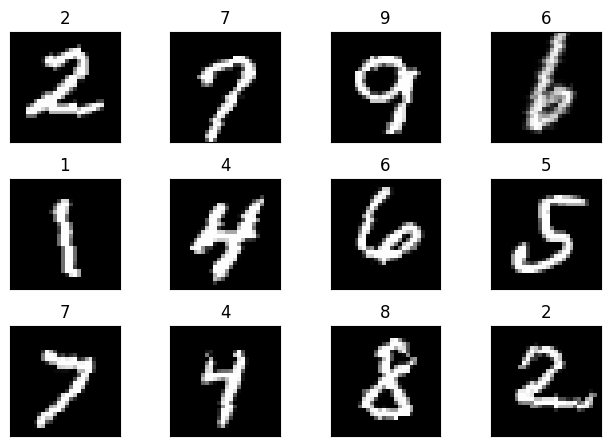

In [ ]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

### Code Block 7 is Replaced

In [ ]:
#Create a model object
#`.to(device)`: Send object to Graphic card.
model = Net().to(device)
#Summarize the architecture and paramters of the model

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


CODE BLOCK: 8

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 8

In [ ]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

CODE BLOCK: 9

In [ ]:
model = Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.4258 Batch_id=117 Accuracy=53.59: 100%|██████████| 118/118 [00:21<00:00,  5.41it/s]


Test set: Average loss: 0.1968, Accuracy: 9424/10000 (94.24%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.0910 Batch_id=117 Accuracy=94.23: 100%|██████████| 118/118 [00:20<00:00,  5.64it/s]


Test set: Average loss: 0.0853, Accuracy: 9739/10000 (97.39%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0399 Batch_id=117 Accuracy=96.17: 100%|██████████| 118/118 [00:21<00:00,  5.41it/s]


Test set: Average loss: 0.0690, Accuracy: 9788/10000 (97.88%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0616 Batch_id=117 Accuracy=97.00: 100%|██████████| 118/118 [00:20<00:00,  5.64it/s]


Test set: Average loss: 0.0523, Accuracy: 9815/10000 (98.15%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0764 Batch_id=117 Accuracy=97.55: 100%|██████████| 118/118 [00:21<00:00,  5.41it/s]


Test set: Average loss: 0.0435, Accuracy: 9847/10000 (98.47%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0640 Batch_id=117 Accuracy=97.88: 100%|██████████| 118/118 [00:23<00:00,  4.98it/s]


Test set: Average loss: 0.0444, Accuracy: 9857/10000 (98.57%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0712 Batch_id=117 Accuracy=97.98: 100%|██████████| 118/118 [00:21<00:00,  5.40it/s]


Test set: Average loss: 0.0345, Accuracy: 9889/10000 (98.89%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0098 Batch_id=117 Accuracy=98.28: 100%|██████████| 118/118 [00:21<00:00,  5.39it/s]


Test set: Average loss: 0.0351, Accuracy: 9887/10000 (98.87%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0177 Batch_id=117 Accuracy=98.39: 100%|██████████| 118/118 [00:22<00:00,  5.13it/s]


Test set: Average loss: 0.0315, Accuracy: 9897/10000 (98.97%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0170 Batch_id=117 Accuracy=98.49: 100%|██████████| 118/118 [00:22<00:00,  5.26it/s]


Test set: Average loss: 0.0301, Accuracy: 9904/10000 (99.04%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0146 Batch_id=117 Accuracy=98.54: 100%|██████████| 118/118 [00:22<00:00,  5.21it/s]


Test set: Average loss: 0.0307, Accuracy: 9900/10000 (99.00%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0043 Batch_id=117 Accuracy=98.62: 100%|██████████| 118/118 [00:22<00:00,  5.32it/s]


Test set: Average loss: 0.0251, Accuracy: 9920/10000 (99.20%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0300 Batch_id=117 Accuracy=98.79: 100%|██████████| 118/118 [00:22<00:00,  5.29it/s]


Test set: Average loss: 0.0262, Accuracy: 9913/10000 (99.13%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0523 Batch_id=117 Accuracy=98.81: 100%|██████████| 118/118 [00:23<00:00,  5.00it/s]


Test set: Average loss: 0.0245, Accuracy: 9917/10000 (99.17%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0516 Batch_id=117 Accuracy=98.94: 100%|██████████| 118/118 [00:21<00:00,  5.49it/s]


Test set: Average loss: 0.0278, Accuracy: 9913/10000 (99.13%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0104 Batch_id=117 Accuracy=99.09: 100%|██████████| 118/118 [00:21<00:00,  5.40it/s]


Test set: Average loss: 0.0220, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0134 Batch_id=117 Accuracy=99.22: 100%|██████████| 118/118 [00:21<00:00,  5.46it/s]


Test set: Average loss: 0.0216, Accuracy: 9927/10000 (99.27%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0291 Batch_id=117 Accuracy=99.21: 100%|██████████| 118/118 [00:21<00:00,  5.38it/s]


Test set: Average loss: 0.0212, Accuracy: 9925/10000 (99.25%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0097 Batch_id=117 Accuracy=99.22: 100%|██████████| 118/118 [00:23<00:00,  5.10it/s]


Test set: Average loss: 0.0209, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0156 Batch_id=117 Accuracy=99.20: 100%|██████████| 118/118 [00:23<00:00,  5.11it/s]


Test set: Average loss: 0.0211, Accuracy: 9924/10000 (99.24%)

Adjusting learning rate of group 0 to 1.0000e-03.


Text(0.5, 1.0, 'Test Accuracy')

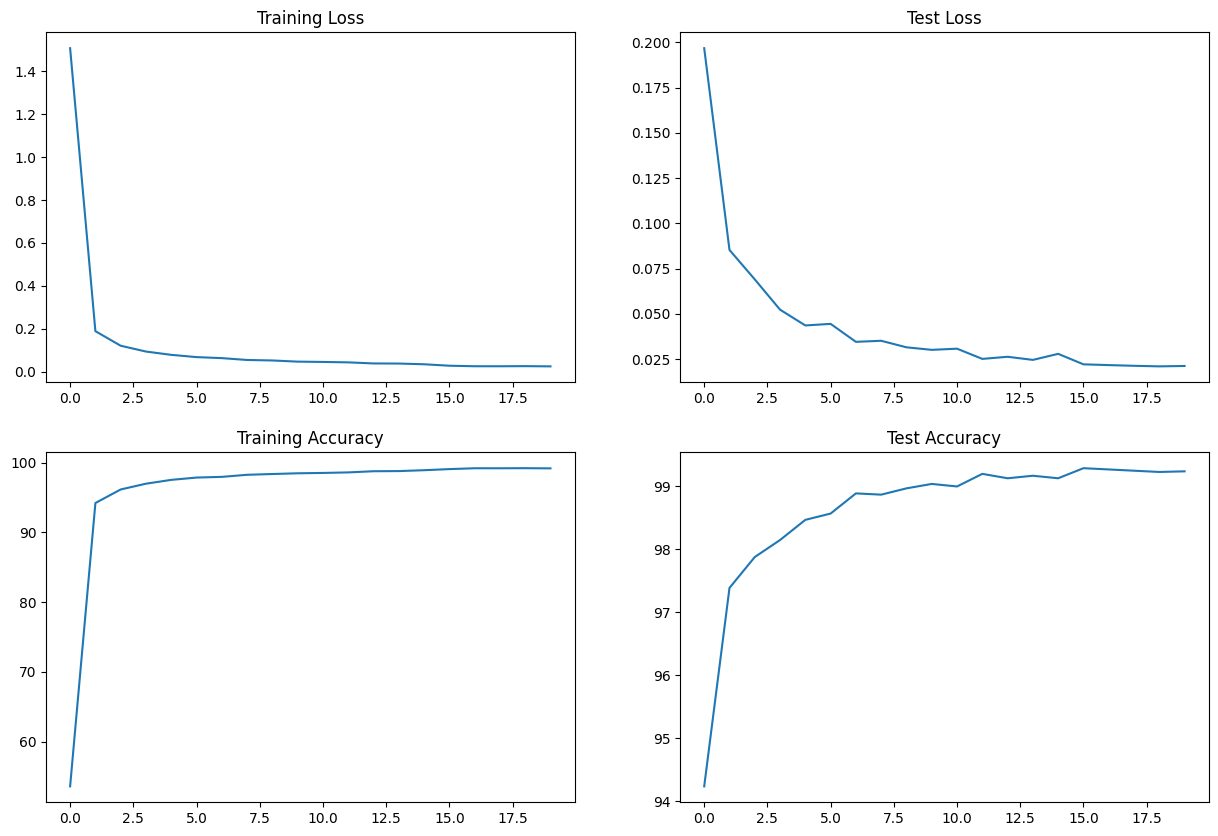

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------
